In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import load_hr_image,bicubic_downsample,extract_patches_unfold,visualize_patches_grid,super_resolve_patches,merge_patches_fold,load_single_image,super_resolve_full_image
from PIL import Image
import torch
from skimage.metrics import peak_signal_noise_ratio as psnr
import cv2
import os

In [14]:
SCALE = 4  # or 3/4 depending on what you trained
PATCH_SIZE = 96
OVERLAP = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from types import SimpleNamespace

args = SimpleNamespace()
args.scale = [SCALE]
args.n_resblocks = 32
args.n_feats = 256
args.rgb_range = 255
args.n_colors = 3
args.res_scale = 0.1
args.no_upsampling = False
args.act = 'relu'


from model.edsr import EDSR
model = EDSR(args).to(device)

ckpt = torch.load('../experiment/edsr_x4_mydataset_hyperparams/model/model_best.pt', map_location=device)
model.load_state_dict(ckpt)
model.eval()


EDSR(
  (sub_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (add_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (head): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (body): Sequential(
    (0): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (2): ResBlock(
      (body): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [15]:
image_path = 'C:/Users/nicol/Desktop/UNI/3.Master/MasterThesis/PracticalPart/dataset_generation/DIAGRAMS/test/HR/bar_chart_20250519_081655_ec01b7db.png'
#hr_img = load_hr_image(image_path)
#hr_img_shape = hr_img.shape
image = cv2.imread(image_path)
hr_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)	
hr_img_shape = hr_img.shape
print(hr_img_shape,str(type(hr_img))) 

#image_folder = 'C:/Users/nicol/Desktop/UNI/3.Master/MasterThesis/PracticalPart/dataset_generation/DIAGRAMS_CUSTOM_LOSS/test/HR' 
#img_list = os.listdir(image_folder)
#rnd_img = np.random.choice(img_list)
#rnd_img = load_single_image(os.path.join(image_folder, rnd_img))
#hr_img = rnd_img
hr_img_shape = hr_img.shape


(768, 1024, 3) <class 'numpy.ndarray'>


lr_patches.shape = torch.Size([1, 3, 96, 96, 12])


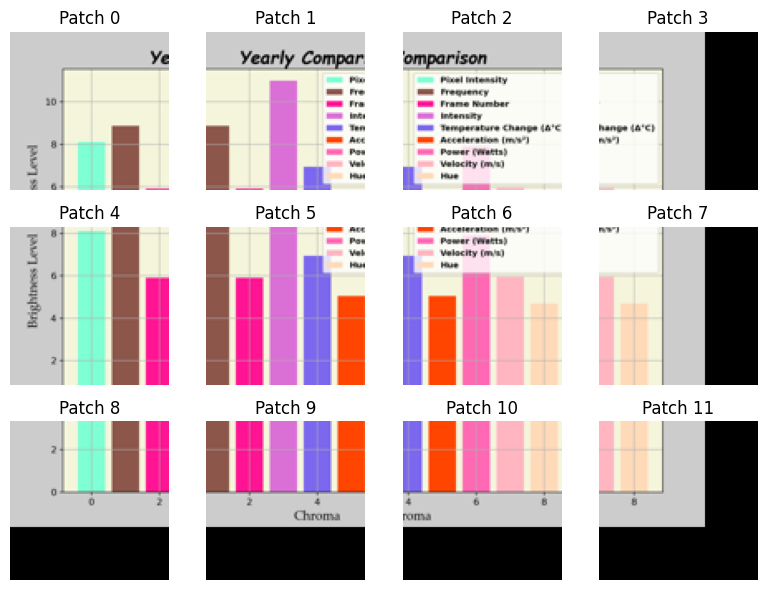

In [16]:
lr_image = bicubic_downsample(hr_img,scale_factor=SCALE)
lr_image_np = np.array(lr_image)
h, w, c = lr_image_np.shape                 
lr_image_shape = (h, w)
patches,unfold_shape = extract_patches_unfold(lr_image_np,patch_size=PATCH_SIZE,overlap=OVERLAP,hr_shape=hr_img_shape[:2],scale=SCALE)
print("lr_patches.shape =", patches.shape) 
visualize_patches_grid(patches,unfold_shape[0:4])

In [17]:
full_sr = super_resolve_full_image(lr_image_np, model,args)

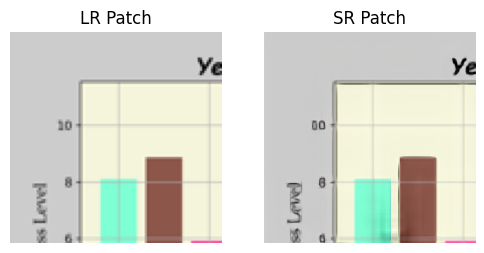

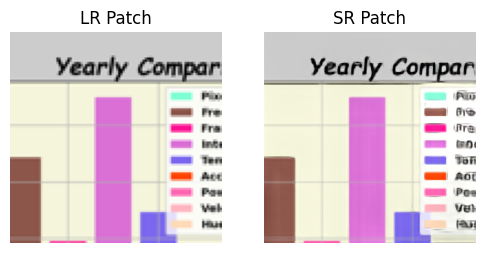

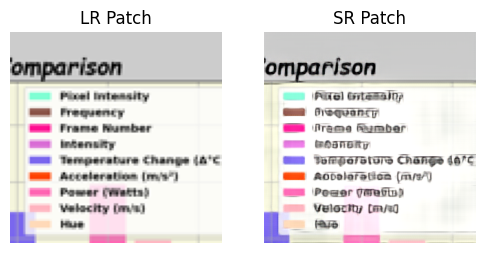

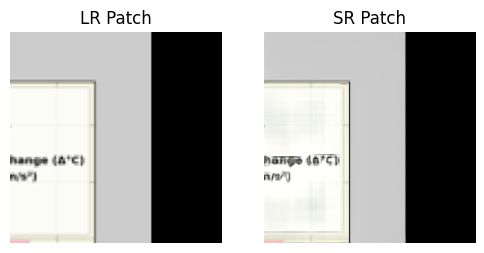

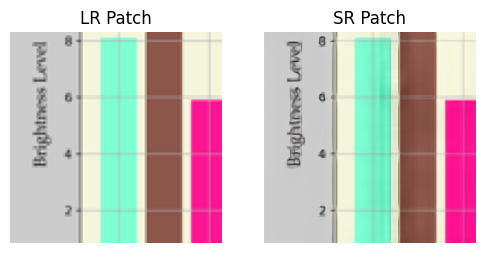

sr_patches.shape = torch.Size([1, 3, 384, 384, 12])


In [18]:
sr_patches = super_resolve_patches(patches, model,args, device="cuda", vis=True)
print("sr_patches.shape =", sr_patches.shape)

final_sr.shape = torch.Size([1, 3, 768, 1024])
hr image shape: (768, 1024, 3)
lr image shape: (192, 256)
PSNR value of gt with path wise inference: 19.81799314990823
PSNR value of gt and full inference: 19.8214344995627
final_sr.shape = (768, 1024, 3)


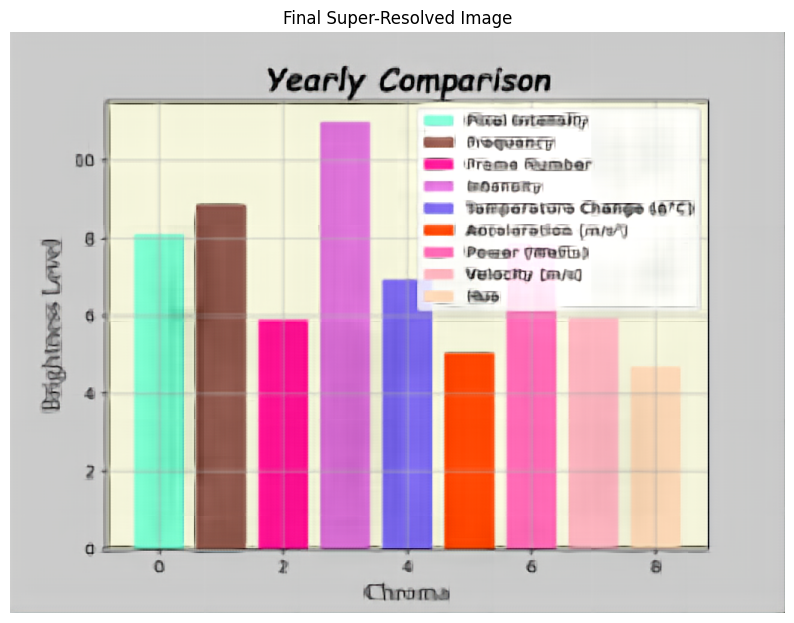

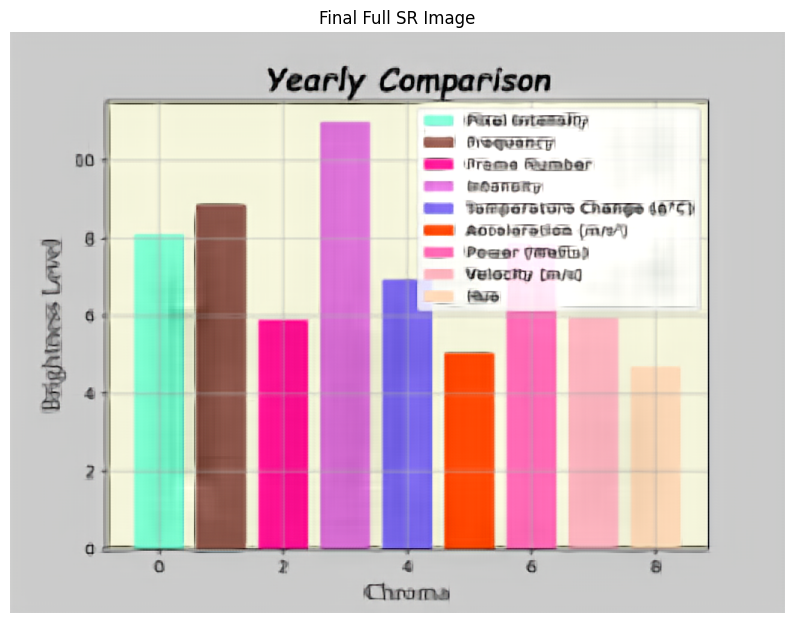

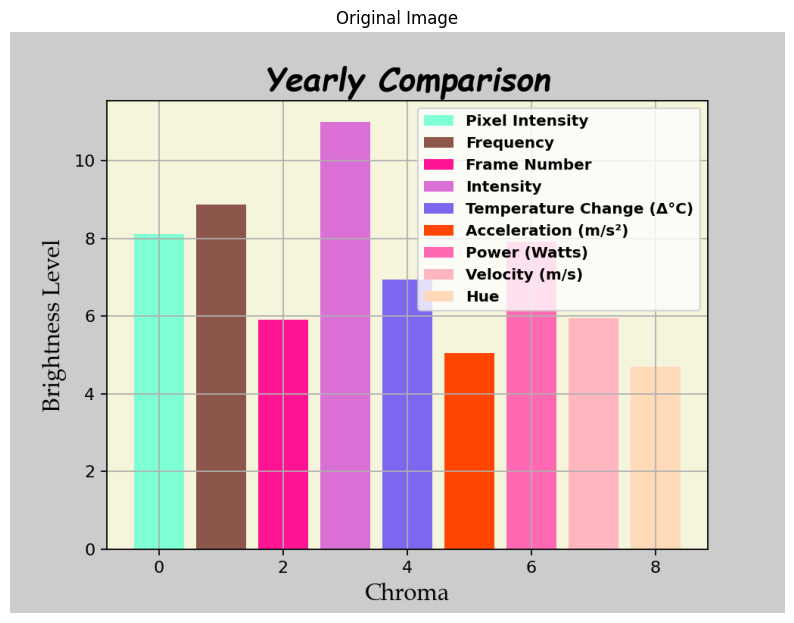

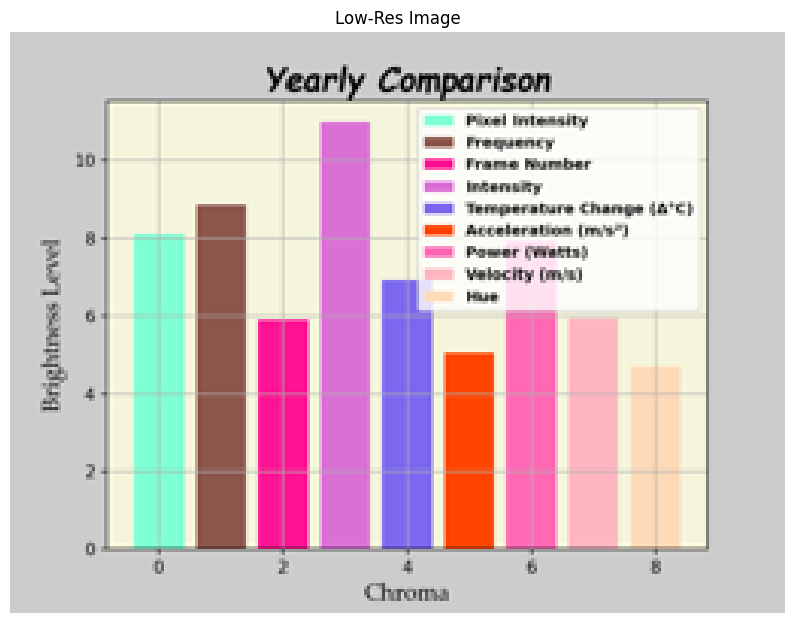

In [19]:
final_sr = merge_patches_fold(sr_patches,lr_image_shape=unfold_shape,patch_size=PATCH_SIZE,overlap=OVERLAP)
print("final_sr.shape =", final_sr.shape) 
print("hr image shape:",hr_img_shape)
print("lr image shape:", lr_image_shape)
sr_image = final_sr.squeeze(0)  
sr_image = sr_image.permute(1, 2, 0).cpu().numpy() 
if sr_image.max() <= 1.0:
    sr_image = (sr_image * 255.0).clip(0, 255)

sr_image = sr_image.astype(np.uint8)
psnr_val_patch = psnr(sr_image, hr_img, data_range=255)
psnr_val_full = psnr(full_sr, hr_img, data_range=255)
print("PSNR value of gt with path wise inference:", psnr_val_patch)
print("PSNR value of gt and full inference:", psnr_val_full)
print("final_sr.shape =", sr_image.shape) 
plt.figure(figsize=(10,10))
plt.imshow(sr_image)
plt.title("Final Super-Resolved Image")
plt.axis("off")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(full_sr)
plt.title("Final Full SR Image")
plt.axis("off")
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(hr_img)
plt.title("Original Image")
plt.axis("off")
plt.show()


plt.figure(figsize=(10,10))
plt.imshow(lr_image)
plt.title("Low-Res Image")
plt.axis("off")
plt.show()

In [20]:
#Image.fromarray(sr_image).save('sr_imgs/sr_image2.png')